In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, recall_score, precision_score, f1_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVR

%matplotlib inline

In [2]:
df = pd.read_csv('AMZN_formatted.csv', index_col = 0)
df.dropna(inplace = True)

In [3]:
df.index = pd.to_datetime(df.index)

In [4]:
df2 = df.drop(['sma252','sma50','ema22zone','ema252zone', 'ema50', 'BBU_5_2.0', 'ema7zone', 'sma22', 'ema50zone', 'BBL_5_2.0', 'BBM_5_2.0', 'ema22', 'sma7','ema252'],axis = 1)

In [5]:
corrs = df2.corr().stack().reset_index()
corrs.columns = ['1','2','R2']
temp = corrs[(corrs.R2 > .8) & (corrs.R2 < .999)].sort_values('R2', ascending = False).reset_index(drop = True)
correlations = temp[temp.index % 2 == 0]

In [6]:
correlations

,1,2,R2


In [7]:
df2 = df2[df2.index > '2010-1-1']

In [8]:
X = df2.shift(1).dropna()
y = df2['adjustedclose'].iloc[1:]

In [9]:
train_num = round(len(X)*.8)
test_num = round(len(X)*.2)
print(train_num, test_num)

2410 602


In [10]:
X_train = X.iloc[:train_num]
X_test = X.iloc[-test_num:]
y_train = y.iloc[:train_num]
y_test = y.iloc[-test_num:]

In [11]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns).set_index(X_test.index)

In [12]:
svr = LinearSVR(random_state = 42, max_iter = 10e5)

In [13]:
svrmodel = svr.fit(X_train_scaled, y_train)

In [14]:
train_score = svr.score(X_train_scaled, y_train)
y_hat_train = svr.predict(X_train_scaled)
train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
train_cv_score = cross_val_score(svrmodel, X_train_scaled, y_train, n_jobs = -1).mean()

print(f'Train Score : {train_score}')
print(f'Train RMSE : {train_rmse}')
print(f'Mean Train Cross-Validation Score: {train_cv_score}')

Train Score : 0.9990666685968811
Train RMSE : 16.62305733842833
Mean Train Cross-Validation Score: 0.9727137028953553


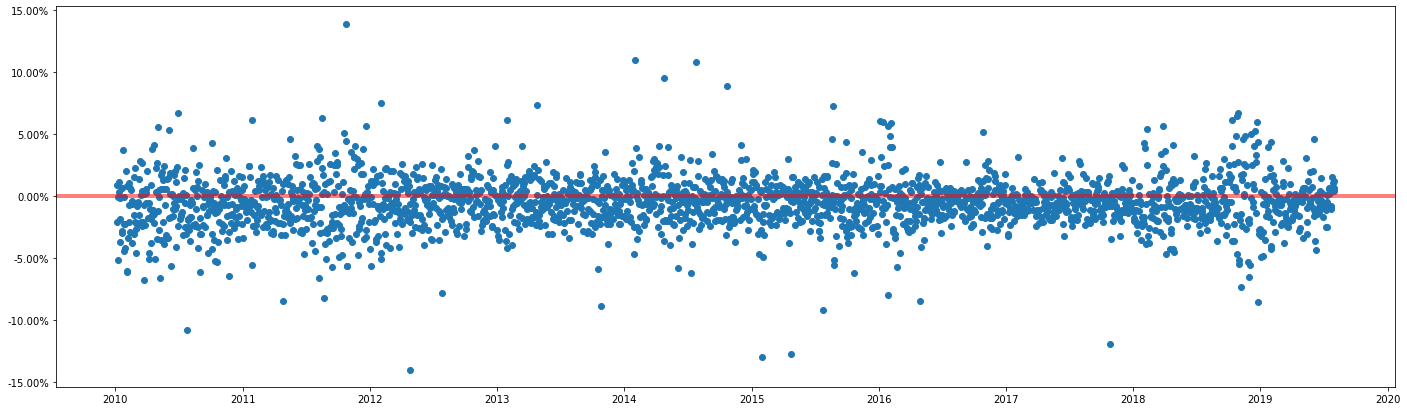

In [15]:
fig, ax = plt.subplots(figsize = (24,7))
plot_x = y_train.index
plot_y = (y_hat_train - y_train)/y_train
plt.scatter(plot_x,plot_y)
ax.yaxis.set_major_formatter('{x:1,.2%}')
plt.axhline(y=0, alpha = .5, color = 'red', linewidth = 4.0);

In [16]:
test_score = svr.score(X_test_scaled, y_test)
y_hat_test = svr.predict(X_test_scaled)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(f'Test Score : {test_score}')
print(f'Test RMSE : {test_rmse}')

Test Score : 0.9926482794436489
Test RMSE : 57.01157057774098


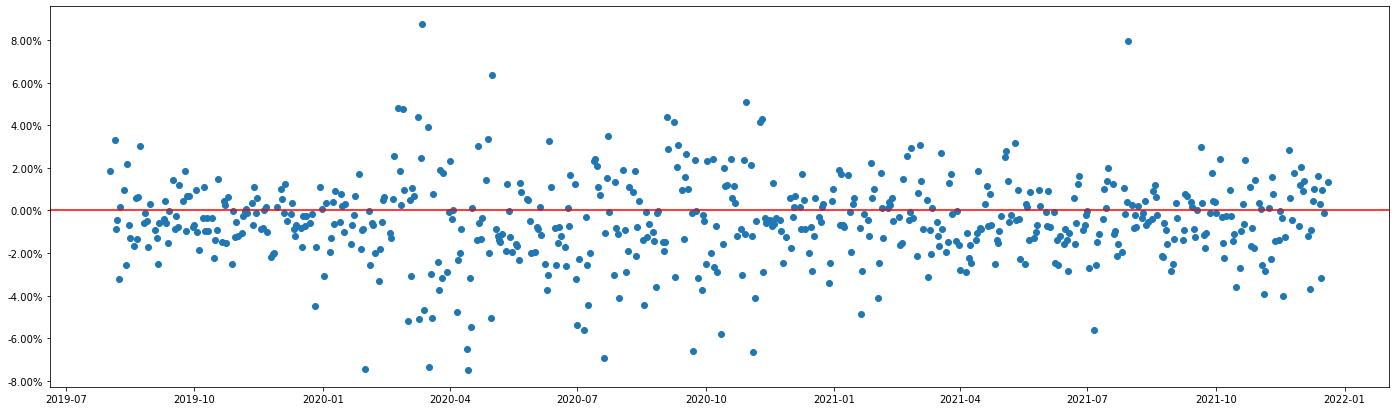

In [17]:
fig2, ax = plt.subplots(figsize = (24,7))
ax.scatter(y_test.index, (y_hat_test - y_test)/y_test)
ax.yaxis.set_major_formatter('{x:1,.2%}')
plt.axhline(y=0, alpha = 1, color = 'red');

In [18]:
preds_train = pd.concat([y_train, pd.DataFrame(y_hat_train, columns = ['predictions'], index = y_train.index), df2.day_direction], axis = 1)
preds_train.dropna(inplace = True)

In [19]:
preds_train['direction'] = np.where(preds_train.predictions > preds_train.adjustedclose.shift(1), 1, 0)
preds_train['correct'] = np.where(preds_train['direction'] == preds_train['day_direction'], 1, 0)
preds_train['correct'].value_counts(normalize = True)

0    0.509129
1    0.490871
Name: correct, dtype: float64

In [26]:
preds_test['direction'] = np.where(preds_test.predictions > preds_test.adjustedclose.shift(1), 1, 0)
preds_test['correct'] = np.where(preds_test['direction'] == preds_test['day_direction'], 1, 0)
preds_test['correct'].value_counts(normalize = True)

0    0.527713
1    0.472287
Name: correct, dtype: float64

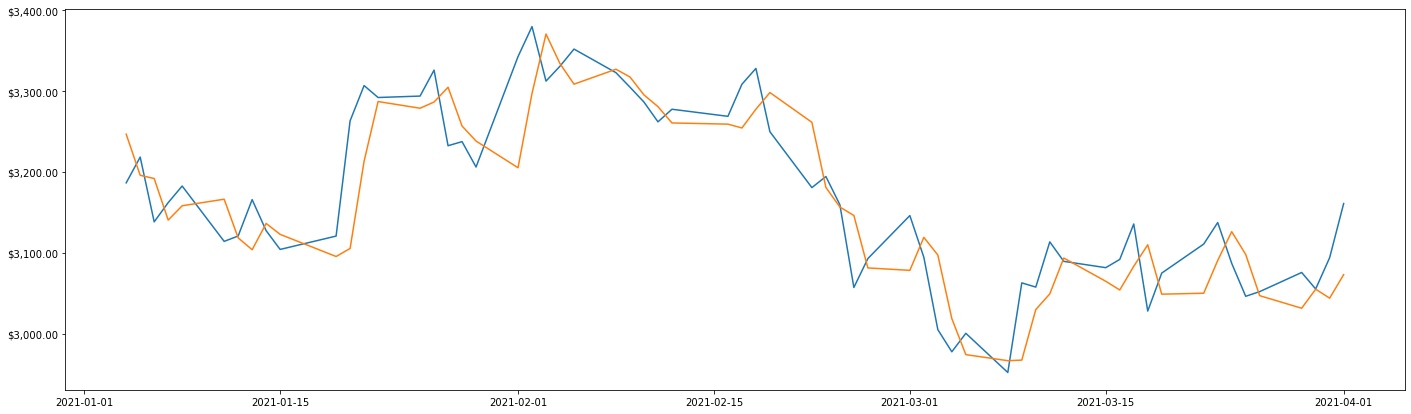

In [34]:
fig3, ax = plt.subplots(figsize = (24,7))
fig3_data = preds_test[(preds_test.index >= '1-1-2021') & (preds_test.index <= '4-1-2021')]
ax.plot(fig3_data.adjustedclose)
ax.plot(fig3_data.predictions)
ax.yaxis.set_major_formatter('${x:1,.2f}');